<a href="https://colab.research.google.com/github/milipaget/Redes-Neuronales-Paget/blob/main/TP1_Redes_Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

In [3]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras import optimizers
from keras.utils import np_utils
import keras.backend as K

In [5]:
import sklearn.metrics
from sklearn.metrics import f1_score
import sys 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Problema de clasificación:

## **Consigna problema de clasificación**
1.   EDA: Visualizar algunas instancias de cada clase. Hacer histogramas de la distribución de intensidades para cada clase, cualquier otra propuesta es bienvenida.
2.   Modelos: Entrenar un modelo de clasificación en las 10 clases de Fashion MNIST. Regresión softmax y MLP. En el caso que corresponda probar y comparar: distintas funciones de activación, distintos optimizadores, distintas funciones de costo, distintos tamaños de red (cantidad de capas y tamaño de cada capa), learning rate, batch_size, dropout rates, batch_normalization (si/no), inicializaciones de pesos (glorot_uniform,glorot_normal, normal(0,1), normal(0,0.001)). Métricas a reportar para cada entrenamiento de interés: Accuracy como métrica principal. Como métricas secundarias: curva ROC, área bajo la curva ROC, F1-score, Precisión y Recall. Enunciar para el F1-score y el área bajo la curva ROC cómo se calculan los promedios macro y micro. Justificar cuál de los dos es el que corresponde reportar en este problema. Para un buen modelo obtenido en el punto anterior (así si lo mejoran no tienen que repetireste punto), variar los hiperparámetros de a uno y graficar:

    *   Accuracy vs [LEARNING_RATE, BATCH_SIZE, OPTIMIZADORES, ACTIVACIONES,DROPOUT_RATE, BATCH_NORMALIZATION, INICIALIZACIONES DE PESOS]
    *   Iteraciones de entrenamiento vs [LEARNING_RATE, BATCH_SIZE, OPTIMIZADORES,ACTIVACIONES, DROPOUT_RATE, BATCH_NORMALIZATION, INICIALIZACIONES DEPESOS]
Intente justificar los gráficos obtenidos.Valores mínimos esperados para cada modelo: SoftmaxReg: 0.70, MLP: .83
3. El mejor modelo debe ser reentrenado agregando una capa de tamaño 2 antes de la desalida. Mapear los datos de entrada a la salida de la capa agregada y graficarla con los labels correspondientes. Superponer en el mismo gráfico los umbrales de decisión. Para obtener los umbrales de decisión se debe armar una grilla de puntos que debe darse como input a la última capa de la red neuronal (softmax) y tomar el argumento máximo como clase correspondiente. Se alienta a intentar aumentar los datos de entrenamiento haciendo espejamiento de las imágenes en las situaciones que tenga sentido hacerlo. Una vez entregado el TP se pueden seguir subiendo predicciones de modelos nuevos a Kaggle hasta el final de la cursada.
4. Para un buen conjunto de hiperparámetros de un MLP obtenido en 2, entrenar de la siguiente manera:
      *   Salvar la red inicializada con pesos aleatorios (antes de entrenar). La llamaremos red 1.
      * Entrenar la red. La llamaremos red 2.
      * Comparar los pesos obtenidos en red 2 con los pesos de inicialización (red 1) y marcar a aquel 50% que más haya variado.
      * Sobre la red 1 eliminar los pesos que no hayan sido marcados en el punto anterior. La llamaremos red 3.
      * Sin entrenar, medir el accuracy de red 3.
      * Entrenar la red 3 (de 1/2 del tamaño original) y comparar la métrica con la métrica obtenida con red 2.
      * Discutiremos los resultados en clase.

In [7]:
#Obtengo los archivos dato
submission = pd.read_csv('/content/drive/My Drive/TP1 Redes Neuronales/submission.csv')
train_labels = pd.read_csv('/content/drive/My Drive/TP1 Redes Neuronales/train_labels.csv')
train_imgs = np.load('/content/drive/My Drive/TP1 Redes Neuronales/train_images.npy')
test_imgs = np.load('/content/drive/My Drive/TP1 Redes Neuronales/test_images.npy')

In [8]:
#Separo un 20% del dataset para validación
validation = 0.20
N_validation_split = int(train_imgs.shape[0]*(1-validation))
# Training Set
x_train = train_imgs[:N_validation_split]
y_train = train_labels[:N_validation_split]

# Cross Validation Set
x_val = train_imgs[N_validation_split:]
y_val = train_labels[N_validation_split:]

#Creo un array con el nombre de las clases
clases = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

**EDA:** Visualización de algunas instancias de cada clase, histogramas y ver como se ve una imagen cualquiera.

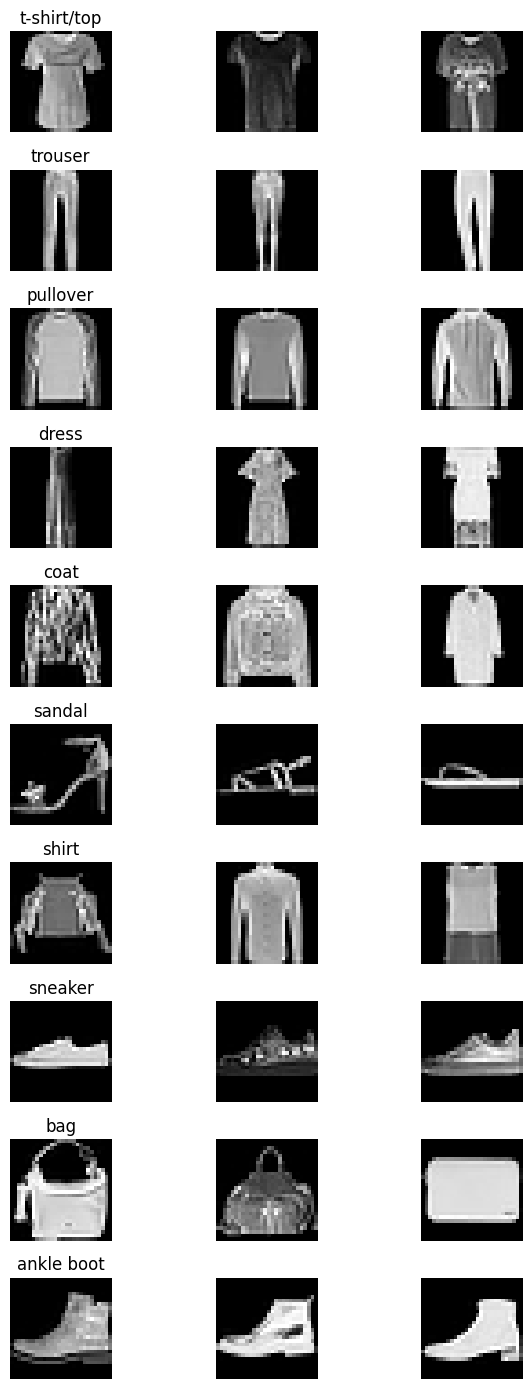

In [8]:
#Voy a ver 3 imágenes de cada una de las 10 clases
fig1,axs = plt.subplots(10, 3, figsize=(7, 14))
for i in range(10):
  indice = np.where(y_train == i)[0] #Encuentra dónde coincide el label
  np.random.shuffle(indice) #Selecciona random de ese subset de data que encontró
  for j in range(3):
    axs[i,j].imshow(x_train[indice[j]], cmap='gray')
    axs[i,j].axis('off') #Saca las escalas
    if j==0:
      axs[i,j].set_title(clases[i])
plt.tight_layout()
plt.show()

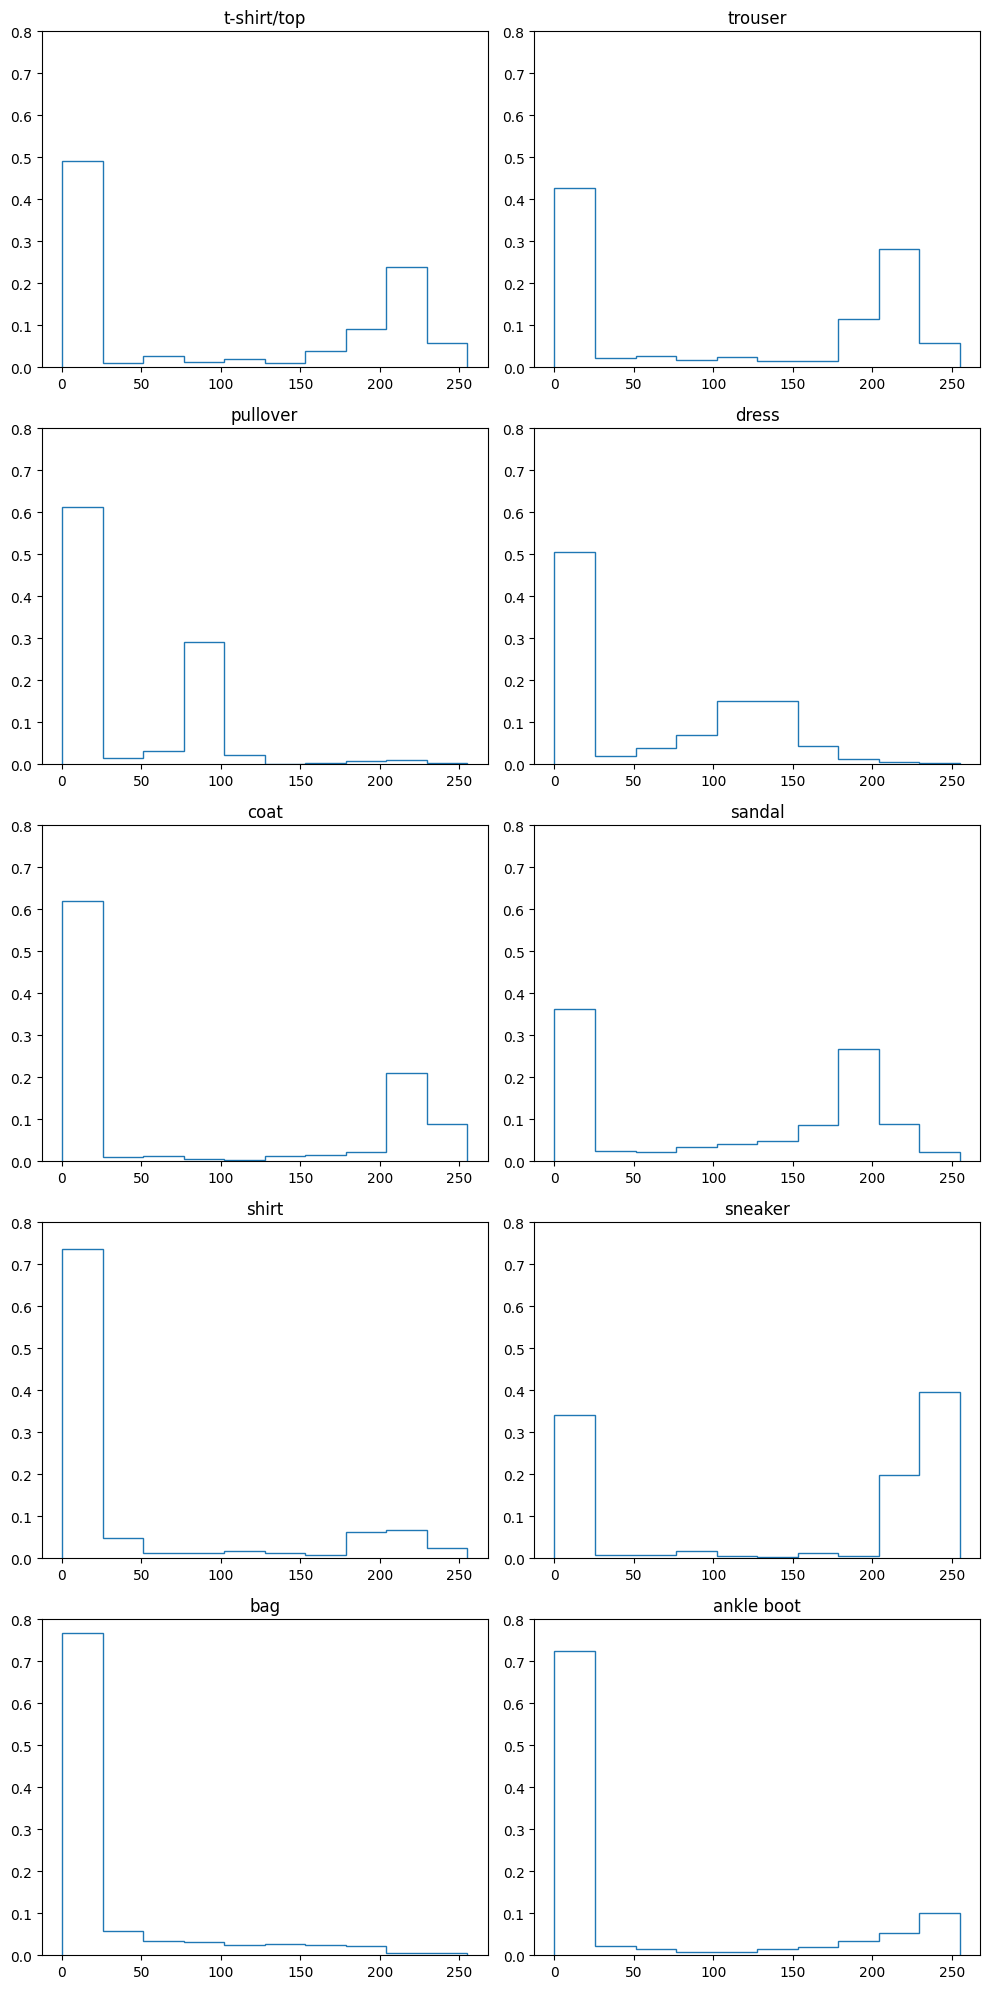

In [9]:
#Histograma
fig2,axs = plt.subplots(5,2,figsize=(10,20))
for indice, ax in enumerate(axs.flatten()):
  counts, bins = np.histogram(x_train[indice].flatten())
  ax.stairs(counts/x_train[indice].flatten().size, bins)
  ax.set_ylim([0,0.8])
  ax.set_title(str((clases[indice])))

plt.tight_layout()
plt.show()


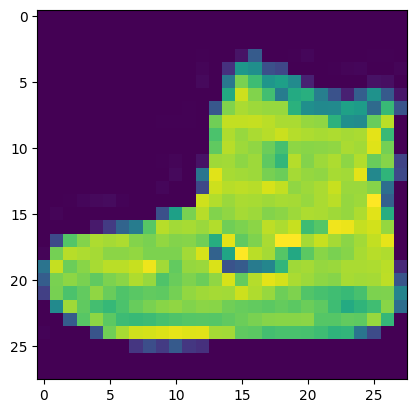

In [ ]:
plt.imshow(x_train[0,...])

In [10]:
#NORMALIZAR :)
x_train = x_train/255
x_val = x_val/255

output_size = 10

y_train2 = keras.utils.to_categorical(y_train)
y_val2 = keras.utils.to_categorical(y_val)

**Regresión SOFTMAX:**

Para entrenar un modelo con regresión SOFTMAX primero se debe definir el modelo para luego entrenarlo

In [19]:
#Defino el modelo
K.clear_session()
model_soft=Sequential()
model_soft.add(Flatten(input_shape=(28,28)))
model_soft.add(Dense(10, activation='softmax'))
model_soft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [20]:
#Compilo el modelo
lr = 0.0001
adam = optimizers.Adam(learning_rate=lr)
model_soft.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy', keras.metrics.Precision(), keras.metrics.AUC(), keras.metrics.Recall()])

In [21]:
#Entreno el modelo
soft_history=model_soft.fit(x=x_train,
            y=y_train2,
            batch_size = 16,
            epochs = 50,
            verbose = 0,
            validation_data=(x_val, y_val2),
            )

Resultados obtenidos variando algunos de los parámetros:

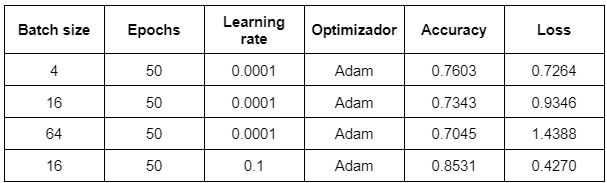

A medida que se aumenta el batch size, el accuracy disminuye y a la vez aumenta la loss. Al disminuir el learning rate se puede ver como el valor del accuracy va mejorando, esto se debe a que un learning rate más bajo permite un ajuste más fino de los pesos del modelo y puede que ayude al modelo a encontrar regiones más óptimas de funcionamiento. Además que un learning rate bajo ayuda a reducir el overfitting. Sin embargo, podemos ver que al aumentar el learning rate a 0.1 el accuracy dio un mejor valor, esto probablemente haya sido causado por un caso de overfitting.  

In [22]:
test_loss, accuracy, precision, auc, recall = model_soft.evaluate(x_val, y_val2, verbose=0)
y_pred = np.argmax(model_soft.predict(x_val), axis=1)
y_val3 = np.argmax(y_val2, axis=1)
f1_macro = f1_score(y_val3, y_pred, average='macro')
f1_micro = f1_score(y_val3, y_pred, average='micro')

print("Para el modelo de regresión SOFTMAX con batch_size=16, lr=0.0001 y optimizador Adam se obtienen los siguientes valores:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)
print("F1-ScoreMacro:", f1_macro)
print("F1-ScoreMicro:", f1_micro)


375/375 [==============================] - 2s 4ms/step
Para el modelo de regresión SOFTMAX con batch_size=16, lr=0.0001 y optimizador Adam se obtienen los siguientes valores:
Accuracy: 0.8582500219345093
Precision: 0.8883490562438965
Recall: 0.8228333592414856
AUC: 0.9886383414268494
F1-ScoreMacro: 0.8581763434874603
F1-ScoreMicro: 0.85825


**MLP:**

Con el objetivo de tener mejores resultados, se fueron modificando ciertos parámetros como son la cantidad de capas, las funciones de activación, los optimizadores, entre otras cosas.



In [9]:
K.clear_session() 

#Definición del modelo
model_mlp= Sequential()
model_mlp.add(Flatten(input_shape=(28,28)))# Esta capa es opcional, se podria haber hecho el flatten antes
model_mlp.add(BatchNormalization())
model_mlp.add(Dropout(0.2)) #dificulta el overfitting
model_mlp.add(Dense(1200, activation='relu', kernel_initializer='glorot_normal'))
model_mlp.add(Dense(1000, activation='relu', kernel_initializer='glorot_normal'))
model_mlp.add(Dense(800, activation='relu', kernel_initializer='glorot_normal'))
model_mlp.add(Dense(600, activation='relu', kernel_initializer='glorot_normal'))
model_mlp.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1200)              942000    
                                                                 
 dense_1 (Dense)             (None, 1000)              1201000   
                                                                 
 dense_2 (Dense)             (None, 800)               800800    
                                                        

In [10]:
# Compilo el modelo
lr = 0.0001
adam = optimizers.Adam(learning_rate=lr)
model_mlp.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy', keras.metrics.Precision(), keras.metrics.AUC(), keras.metrics.Recall()])

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_mlp.save("model_mlp_without_training")
model_mlp.fit(x=x_train,
            y=y_train2,
            batch_size = 16,
            epochs = 50,
            verbose = 1,
            validation_data=(x_val, y_val2),
            callbacks=[early_stopping]
            )
model_mlp.save("model_mlp_trained")


Epoch 1/50
3000/3000 [==============================] - 18s 5ms/step - loss: 0.5199 - accuracy: 0.8115 - precision: 0.8575 - auc: 0.9836 - recall: 0.7642 - val_loss: 0.3697 - val_accuracy: 0.8607 - val_precision: 0.8853 - val_auc: 0.9910 - val_recall: 0.8373
Epoch 2/50
3000/3000 [==============================] - 13s 4ms/step - loss: 0.4021 - accuracy: 0.8497 - precision: 0.8809 - auc: 0.9897 - recall: 0.8204 - val_loss: 0.3686 - val_accuracy: 0.8725 - val_precision: 0.8926 - val_auc: 0.9899 - val_recall: 0.8512
Epoch 3/50
3000/3000 [==============================] - 13s 4ms/step - loss: 0.3628 - accuracy: 0.8649 - precision: 0.8919 - auc: 0.9914 - recall: 0.8399 - val_loss: 0.3262 - val_accuracy: 0.8832 - val_precision: 0.9025 - val_auc: 0.9924 - val_recall: 0.8697
Epoch 4/50
3000/3000 [==============================] - 13s 4ms/step - loss: 0.3379 - accuracy: 0.8730 - precision: 0.8961 - auc: 0.9924 - recall: 0.8503 - val_loss: 0.3220 - val_accuracy: 0.8821 - val_precision: 0.9029 - v

In [12]:
test_loss, accuracy, precision, recall, auc = model_mlp.evaluate(x_val, y_val2, verbose=0)
y_pred = np.argmax(model_mlp.predict(x_val), axis=1)
y_val3 = np.argmax(y_val2, axis=1)
f1_macro = f1_score(y_val3, y_pred, average='macro')
f1_micro = f1_score(y_val3, y_pred, average='micro')

print("Loss:", test_loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)
print("F1-ScoreMacro:", f1_macro)
print("F1-ScoreMicro:", f1_micro)


375/375 [==============================] - 1s 2ms/step
Loss: 0.3023206889629364
Accuracy: 0.8992499709129333
Precision: 0.9114561080932617
Recall: 0.9922157526016235
AUC: 0.89041668176651
F1-ScoreMacro: 0.8985663813734585
F1-ScoreMicro: 0.89925


Para el MLP se probaron diferentes funciones de activación, distintos optimizadores, distintos tamaños de red, diferentes valores de learning rate, batch size, dropout rates, entre otras cosas. A continuación se presenta una tabla con algunos de los resultados obtenidos con las modificaciones. 

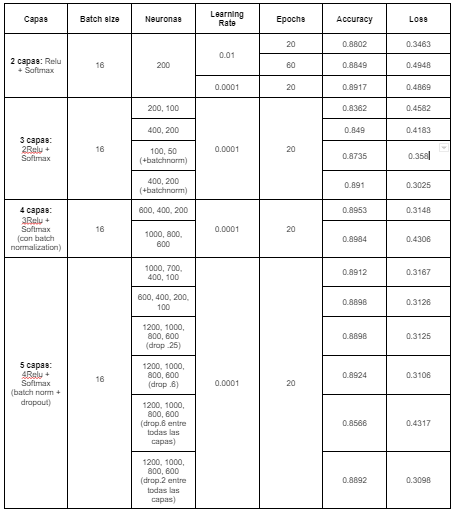

Finalmente se optó por un modelo de 5 capas. Para este modelo se realizaron los gráficos del accuracy y la cantidad de iteraciones de entrenamiento en función de:


*   Learning Rate: [0.1, 0.01, 0.001, 0.0001, 0.00001]
*   Batch Size: [8, 16, 32, 64, 128, 256]
*   Optimizadores: ["adam", "nadam", "adamax", "adagrad", "adadelta"]
*   Activaciones: ['relu', 'exponential', 'linear', 'sigmoid', 'hard_sigmoid'] 
*   Dropout Rates: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
*   Batch Normalization: ['yes', 'no']
*   Inicializaciones de pesos: ['glorot_uniform', 'glorot_normal']


In [ ]:
#Función que entrena el modelo     
def model_train(x_train, y_train, val_data, lr=0.0001, batch_size=32, epochs=50, 
 batch_normalization='yes', dropout=0.2, optimizador='adam', activation='relu', kernel_init='glorot_normal', verbose=0):
  K.clear_session()
  early_stopping = EarlyStopping(monitor='val_loss', patience=3)
  model=Sequential()
  model.add(Flatten(input_shape=(28,28)))# Esta capa es opcional, se podria haber hecho el flatten antes
  if batch_normalization == 'yes':
    model.add(BatchNormalization())
  model.add(Dropout(dropout)) #dificulta el overfitting
  model.add(Dense(1000, activation=activation, kernel_initializer=kernel_init))
  model.add(Dense(800, activation=activation, kernel_initializer=kernel_init))
  model.add(Dense(10, activation='softmax', kernel_initializer=kernel_init))
  
  if verbose==1:
    model.summary()
  
  if optimizador=='adam':
    optimizer = optimizers.Adam(learning_rate=lr)
  elif optimizador=='nadam':
    optimizer = optimizers.Nadam(learning_rate=lr)
  elif optimizador=='adamax':
    optimizer = optimizers.Adamax(learning_rate=lr)
  elif optimizador=='adadelta':
    optimizer = optimizers.Adadelta(learning_rate=lr)
  elif optimizador=='adagrad':
    optimizer = optimizers.Adagrad(learning_rate=lr)
  
  model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  history = model.fit(x=x_train,
            y=y_train2,
            batch_size = batch_size,
            epochs = epochs,
            verbose = verbose,
            validation_data= val_data,
            callbacks = [early_stopping]
            )
  return history


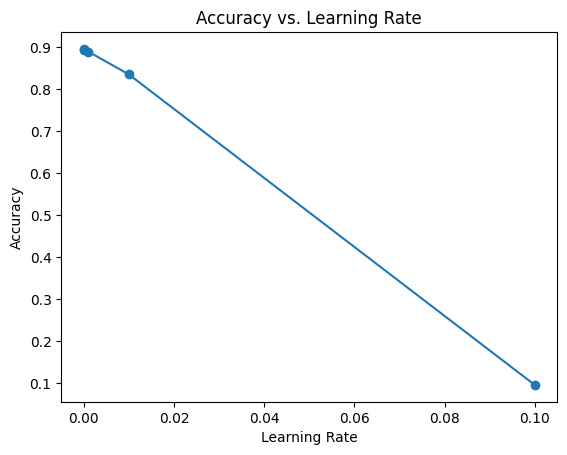

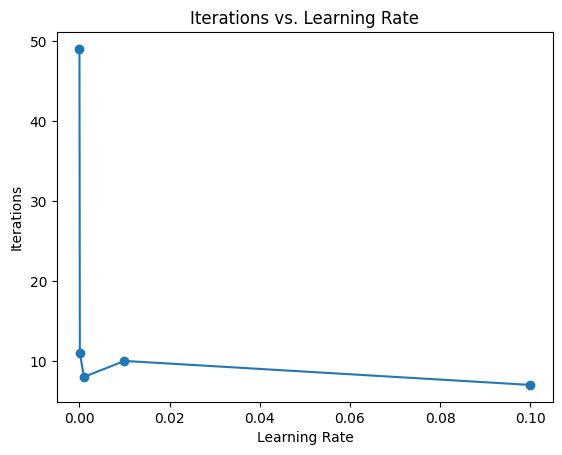

In [ ]:
#Accuracy vs learning rate
accuracies_lr = []
iterations_lr = []
learning_rate = [0.1, 0.01, 0.001, 0.0001, 0.00001]
for lr in learning_rate:
  history = model_train(x_train, y_train, (x_val, y_val2), lr=lr)
  accuracies_lr.append(history.history['val_accuracy'][-1])
  iterations_lr.append(len(history.history['val_accuracy']))

fig1, ax1 = plt.subplots()
ax1.plot(learning_rate, accuracies_lr, 'o-')
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs. Learning Rate')

fig2, ax2 = plt.subplots()
ax2.plot(learning_rate, iterations_lr, 'o-')
ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('Iterations')
ax2.set_title('Iterations vs. Learning Rate')

plt.show()

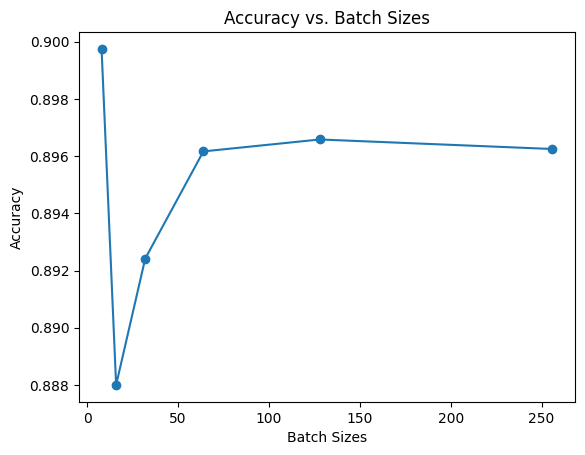

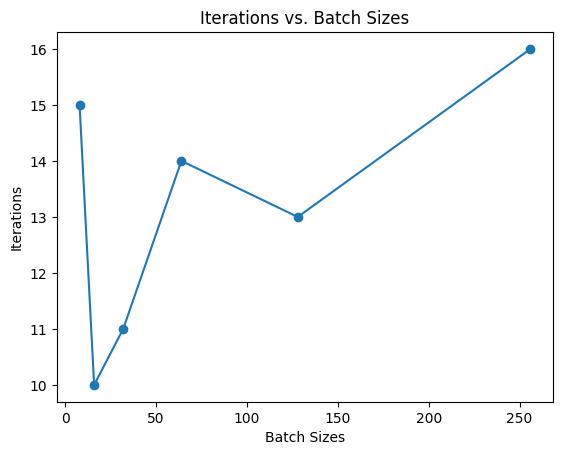

In [ ]:
#Accuracy vs batch size
accuracies_bs = []
batch_sizes = [8, 16, 32, 64, 128, 256]
iterations_bs = []
for batch_size in batch_sizes:
  history = model_train(x_train, y_train, (x_val, y_val2), batch_size=batch_size)
  accuracies_bs.append(history.history['val_accuracy'][-1])
  iterations_bs.append(len(history.history['val_accuracy']))

fig1, ax1 = plt.subplots()
ax1.plot(batch_sizes, accuracies_bs, 'o-')
ax1.set_xlabel('Batch Sizes')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs. Batch Sizes')

fig2, ax2 = plt.subplots()
ax2.plot(batch_sizes, iterations_bs, 'o-')
ax2.set_xlabel('Batch Sizes')
ax2.set_ylabel('Iterations')
ax2.set_title('Iterations vs. Batch Sizes')

plt.show()

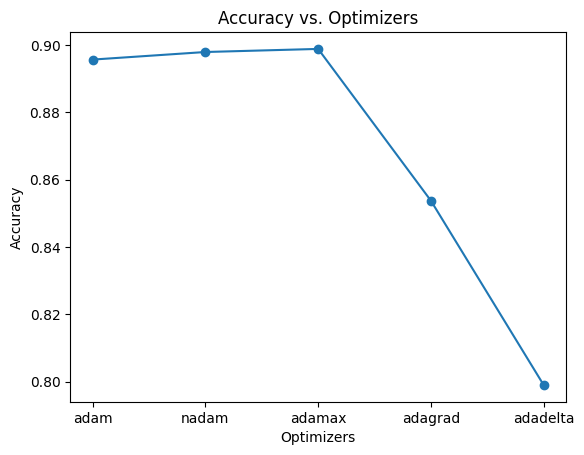

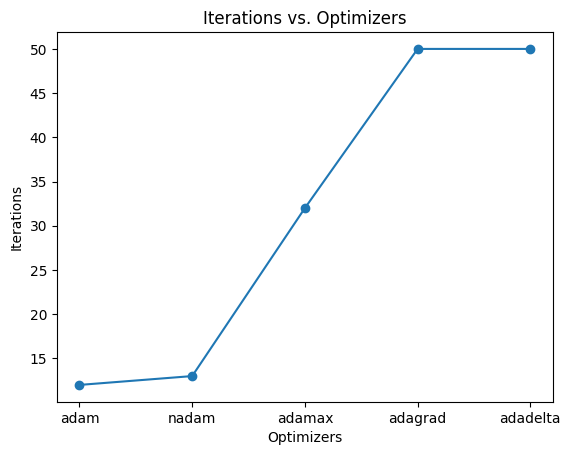

In [ ]:
#Accuracy vs optimizadores
accuracies_opt = []
optimizers_names = ["adam", "nadam", "adamax", "adagrad", "adadelta"]
iterations_opt = []
for opt in optimizers_names:
  history = model_train(x_train, y_train, (x_val, y_val2), optimizador=opt)
  accuracies_opt.append(history.history['val_accuracy'][-1])
  iterations_opt.append(len(history.history['val_accuracy']))

fig1, ax1 = plt.subplots()
ax1.plot(optimizers_names, accuracies_opt, 'o-')
#ax1.xticks(rotation=45)
ax1.set_xlabel('Optimizers')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs. Optimizers')

fig2, ax2 = plt.subplots()
ax2.plot(optimizers_names, iterations_opt, 'o-')
#ax2.xticks(rotation=45)
ax2.set_xlabel('Optimizers')
ax2.set_ylabel('Iterations')
ax2.set_title('Iterations vs. Optimizers')

plt.show()


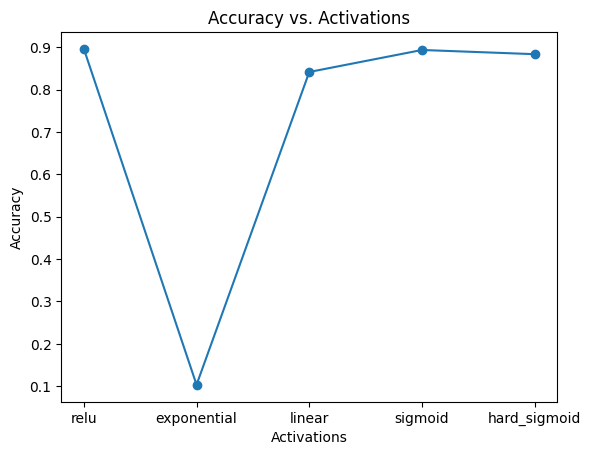

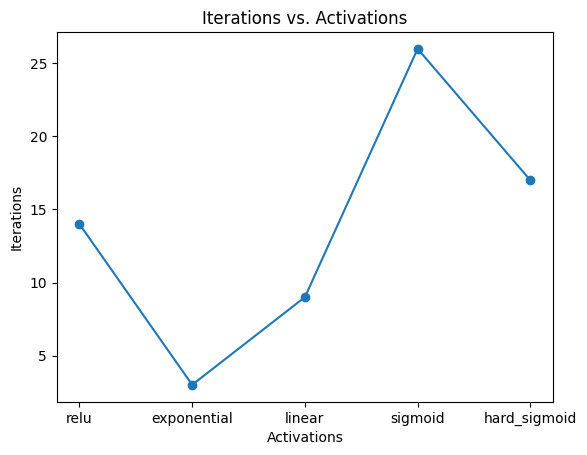

In [ ]:
#Accuracy vs activaciones
accuracies_act = []
activations = ['relu', 'exponential', 'linear', 'sigmoid', 'hard_sigmoid']
iterations_act = []
for act in activations:
  history = model_train(x_train, y_train, (x_val, y_val2), activation=act)
  accuracies_act.append(history.history['val_accuracy'][-1])
  iterations_act.append(len(history.history['val_accuracy']))

fig1, ax1 = plt.subplots()
ax1.plot(activations, accuracies_act, 'o-')
#ax1.xticks(rotation=45)
ax1.set_xlabel('Activations')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs. Activations')

fig2, ax2 = plt.subplots()
ax2.plot(activations, iterations_act, 'o-')
#ax2.xticks(rotation=45)
ax2.set_xlabel('Activations')
ax2.set_ylabel('Iterations')
ax2.set_title('Iterations vs. Activations')

plt.show()

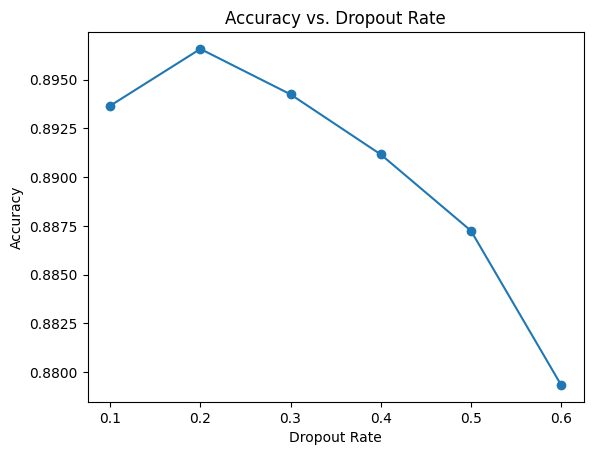

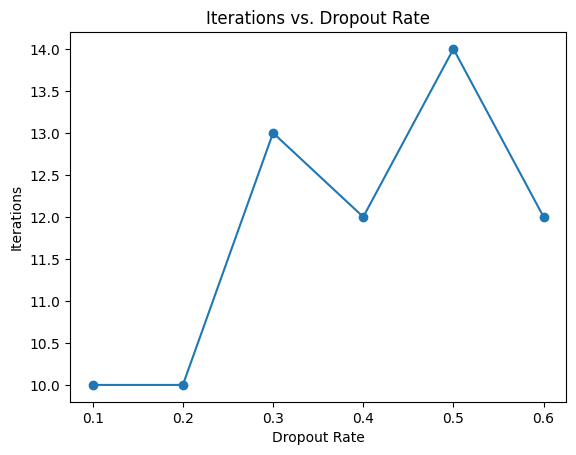

In [ ]:
#Accuracy vs dropout rate
accuracies_drop = []
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
iterations_drop = []
for dropout in dropouts:
  history = model_train(x_train, y_train, (x_val, y_val2), dropout=dropout)
  accuracies_drop.append(history.history['val_accuracy'][-1])
  iterations_drop.append(len(history.history['val_accuracy']))

fig1, ax1 = plt.subplots()
ax1.plot(dropouts, accuracies_drop, 'o-')
#ax1.xticks(rotation=45)
ax1.set_xlabel('Dropout Rate')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs. Dropout Rate')

fig2, ax2 = plt.subplots()
ax2.plot(dropouts, iterations_drop, 'o-')
#ax2.xticks(rotation=45)
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Iterations')
ax2.set_title('Iterations vs. Dropout Rate')

plt.show()

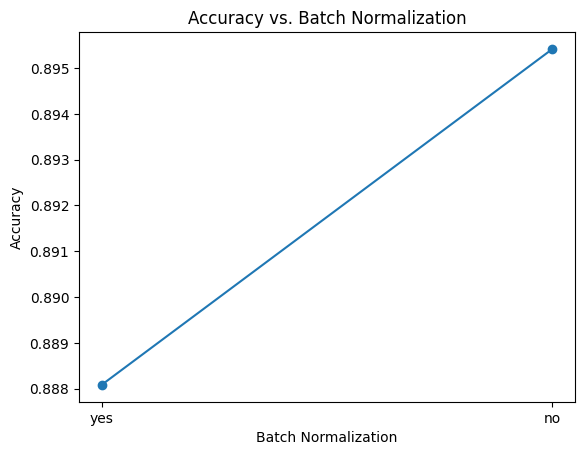

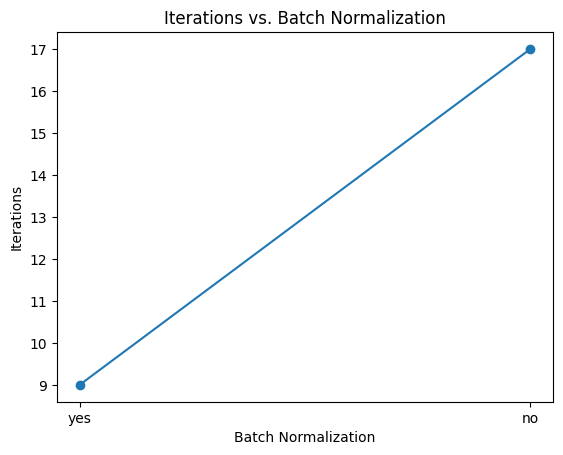

In [ ]:
#Accuracy vs batch normalization
accuracies_bn = []
batch_norm = ['yes', 'no']
iterations_bn = []
for bn in batch_norm:
  history = model_train(x_train, y_train, (x_val, y_val2), batch_normalization=bn)
  accuracies_bn.append(history.history['val_accuracy'][-1])
  iterations_bn.append(len(history.history['val_accuracy']))

fig1, ax1 = plt.subplots()
ax1.plot(batch_norm, accuracies_bn, 'o-')
#ax1.xticks(rotation=45)
ax1.set_xlabel('Batch Normalization')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs. Batch Normalization')

fig2, ax2 = plt.subplots()
ax2.plot(batch_norm, iterations_bn, 'o-')
#ax2.xticks(rotation=45)
ax2.set_xlabel('Batch Normalization')
ax2.set_ylabel('Iterations')
ax2.set_title('Iterations vs. Batch Normalization')

plt.show()

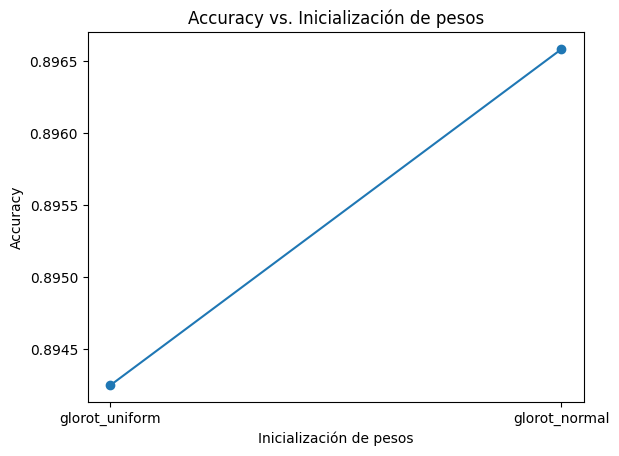

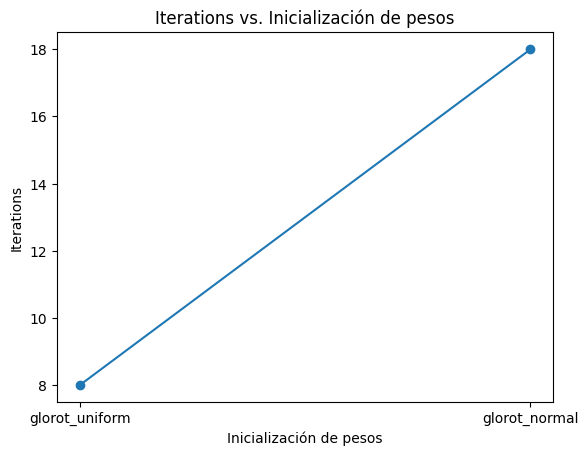

In [ ]:
#Accuracy vs kernel inits
accuracies_init = []
inits = ['glorot_uniform', 'glorot_normal']
iterations_init = []
for init in inits:
  history = model_train(x_train, y_train, (x_val, y_val2), kernel_init=init)
  accuracies_init.append(history.history['val_accuracy'][-1])
  iterations_init.append(len(history.history['val_accuracy']))

fig1, ax1 = plt.subplots()
ax1.plot(inits, accuracies_init, 'o-')
#ax1.xticks(rotation=45)
ax1.set_xlabel('Inicialización de pesos')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs. Inicialización de pesos')

fig2, ax2 = plt.subplots()
ax2.plot(inits, iterations_init, 'o-')
#ax2.xticks(rotation=45)
ax2.set_xlabel('Inicialización de pesos')
ax2.set_ylabel('Iterations')
ax2.set_title('Iterations vs. Inicialización de pesos')

plt.show()

**Punto 3**

In [11]:
#Reentreno el modelo agregando una capa de tamaño 2 antes de la salida
K.clear_session() 

#Definición del modelo. Primero entreno el modelo sin la capa adicional
model_mlp= Sequential()
model_mlp.add(Flatten(input_shape=(28,28)))# Esta capa es opcional, se podria haber hecho el flatten antes
model_mlp.add(BatchNormalization())
model_mlp.add(Dropout(0.2)) #dificulta el overfitting
model_mlp.add(Dense(1200, activation='relu', kernel_initializer='glorot_normal', name='middle1'))
model_mlp.add(Dense(1000, activation='relu', kernel_initializer='glorot_normal', name='middle2'))
model_mlp.add(Dense(800, activation='relu', kernel_initializer='glorot_normal', name='middle3'))
model_mlp.add(Dense(600, activation='relu', kernel_initializer='glorot_normal', name='middle4'))
model_mlp.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal', name='salida'))
model_mlp.summary()

# Compilo el modelo
lr = 0.0001
adam = optimizers.Adam(learning_rate=lr)
model_mlp.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy', keras.metrics.Precision(), keras.metrics.AUC(), keras.metrics.Recall()])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_mlp.fit(x=x_train,
            y=y_train2,
            batch_size = 16,
            epochs = 50,
            verbose = 1,
            validation_data=(x_val, y_val2),
            callbacks=[early_stopping]
            )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 middle1 (Dense)             (None, 1200)              942000    
                                                                 
 middle2 (Dense)             (None, 1000)              1201000   
                                                                 
 middle3 (Dense)             (None, 800)               800800    
                                                        

In [12]:
#Agrgo la nueva capa y lo reentreno
from keras import Model
model_mlp_trunc = Model(model_mlp.input, model_mlp.layers[-2].output)
middle5 = Dense(2, activation='relu', kernel_initializer='glorot_normal', name='middle5')(model_mlp_trunc.output)
salida = Dense(10, activation='softmax', kernel_initializer='glorot_normal', name='salida')(middle5)

model_pto_3 = Model(inputs=model_mlp.input, outputs=salida)
model_pto_3.summary()

model_pto_3.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy', keras.metrics.Precision(), keras.metrics.AUC(), keras.metrics.Recall()])

model_pto_3.fit(x=x_train,
            y=y_train2,
            batch_size = 16,
            epochs = 50,
            verbose = 1,
            validation_data=(x_val, y_val2),
            callbacks=[early_stopping]
            )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_input (InputLayer)  [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 middle1 (Dense)             (None, 1200)              942000    
                                                                 
 middle2 (Dense)             (None, 1000)              1201000   
                                                           

In [13]:
#Mapeo de los datos de entrada a la salida de la capa agregada
capa_agregada = keras.Model(inputs=model_pto_3.input, outputs=model_pto_3.get_layer('middle5').output)
predicciones = capa_agregada.predict(x_train)

1500/1500 [==============================] - 2s 2ms/step


In [14]:
# Grafica los datos mapeados con los labels correspondientes
maxs = np.max(predicciones, axis=0)
mins = np.min(predicciones, axis=0)
# Calculo de entorno
N = 500
x1, x2 = np.meshgrid(np.linspace(mins[0], maxs[0], N), np.linspace(mins[1], maxs[1], N))
x_mesh = np.c_[x1.ravel(), x2.ravel()]
model_extra = Sequential()
model_extra.add(Dense(10, input_shape=(2,)))
model_extra.set_weights(model_pto_3.get_layer('salida').get_weights())
pred_mesh = model_extra.predict(x_mesh, verbose=1)
Z = np.argmax(pred_mesh, axis=1).reshape(x1.shape)/10

7813/7813 [==============================] - 11s 1ms/step


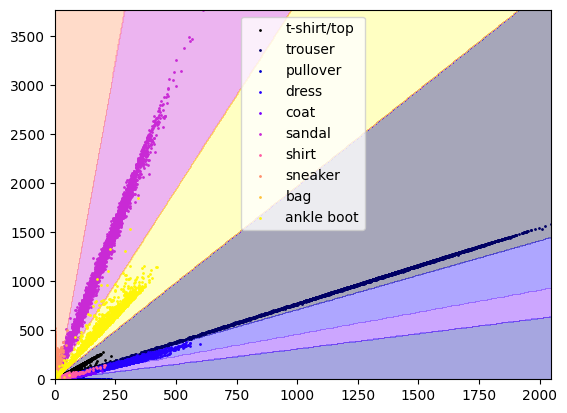

In [16]:
plt.contourf(x1, x2, Z, 10, cmap=plt.cm.gnuplot2, alpha=0.35)
for i in range(10):
  idx = np.where(y_train == i)
  plt.scatter(predicciones[idx, 0], predicciones[idx, 1], label=clases[i], c=[plt.cm.gnuplot2(i/10)], s=1)
plt.legend()
plt.show()

**Punto 4**

In [14]:
K.clear_session()
model_mlp_without_training = keras.models.load_model('model_mlp_without_training')
model_mlp_trained = keras.models.load_model('model_mlp_trained')

#Calculo la diferencia de los pesos
pesos_ini = model_mlp_without_training.get_weights()
pesos_fin = model_mlp_trained.get_weights()

pesos_dif = [np.abs(inicial - final) for inicial, final in zip(pesos_ini, pesos_fin)]

flattened_dif = np.concatenate([arr.flatten() for arr in pesos_dif])
sorted_indices = np.argsort(flattened_dif)[::-1]

threshold_index = int(len(sorted_indices) * 0.5)
threshold = flattened_dif[sorted_indices[threshold_index]]

modified_weights = []
for initial, final in zip(pesos_ini, pesos_fin):
    mask = np.abs(final - initial) >= threshold
    modified_weights.append(np.where(mask, initial, 0.0))

final_model = keras.models.load_model("model_mlp_without_training")
final_model.set_weights(modified_weights)


In [15]:
final_model.fit(x=x_train,
            y=y_train2,
            batch_size = 16,
            epochs = 50,
            verbose = 0,
            validation_data= (x_val, y_val2),
            callbacks = [early_stopping]
            )

In [16]:
test_loss, accuracy, precision, recall, auc = final_model.evaluate(x_val, y_val2, verbose=0)
y_pred = np.argmax(final_model.predict(x_val), axis=1)
y_val3 = np.argmax(y_val2, axis=1)
f1_macro = f1_score(y_val3, y_pred, average='macro')
f1_micro = f1_score(y_val3, y_pred, average='micro')

print("Loss:", test_loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)
print("F1-ScoreMacro:", f1_macro)
print("F1-ScoreMicro:", f1_micro)

375/375 [==============================] - 2s 5ms/step
Loss: 0.315572589635849
Accuracy: 0.8931666612625122
Precision: 0.9044130444526672
Recall: 0.9914278388023376
AUC: 0.8846666812896729
F1-ScoreMacro: 0.8928484315912126
F1-ScoreMicro: 0.8931666666666667


In [ ]:
#Para subirlo a kaggle

x_test = test_imgs/255
y_test = model_mlp.predict(x_test)
labels = np.array([np.argmax(prediction) for prediction in y_test])
submission=pd.DataFrame({"id": np.arange(10000) , "Category" : labels})
submission.to_csv("submission.csv",index=False)

313/313 [==============================] - 2s 7ms/step


## **Consigna problema de regresión**
Se trabajará con el dataset MNIST. Se utilizará información adicional obtenida de https://github.com/dccastro/Morpho-MNIST(original MNIST morphometrics) la cual indica para cada imagen distintas características como ser largo del trazo, inclinación del número, ancho del trazo, etc. Para acceder a los datos es necesario tener instalado tensorflow, descargados los archivos con los metadatos (disponibles en campus) y ejecutar: 
  

*   from tensorflow.keras.datasets
*   import mnistimport pandas as pd
*   (x_train, y_train) , (x_test, y_test) = mnist.load_data()
*   train_morpho = pd.read_csv("train-morpho.csv")
*   test_morpho = pd.read_csv("t10k-morpho.csv")

En este problema intentaremos predecir la inclinación del número en función de:
a. b.  

1.   La imagen
2.   La imagen y el label al que pertenece (Utilizando embeddings de tamaño 2)
3.   La imagen y una variable continua más a elección (a partir de lo visto en el EDA)

EDA: Histogramas de inclinación para cada clase. Scatters entre la inclinación y los otrosdescriptores morfológicos)

Para b. graficar los embeddings obtenidos, intentar explicar lo obtenido.

Modelos: MLP con todas las opciones del punto 2.

Métricas a reportar: MAE


In [27]:
from tensorflow.keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow.keras.layers import Concatenate, Input, Embedding
from tensorflow.keras.models import Model
#from morphomnist import io, morpho, perturb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
test_morpho = pd.read_csv('/content/drive/My Drive/TP1 Redes Neuronales/t10k-morpho.csv')
train_morpho = pd.read_csv('/content/drive/My Drive/TP1 Redes Neuronales/train-morpho.csv')

In [29]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [30]:
print(train_morpho.shape, x_train.shape, y_train.shape)

(60000, 7) (60000, 28, 28) (60000,)


In [31]:
#NORMALIZAR :)
x_train = x_train/255
#x_val = x_val/255
x_test = x_test/255

y_train2 = keras.utils.to_categorical(y_train)
y_test2 = keras.utils.to_categorical(y_test)

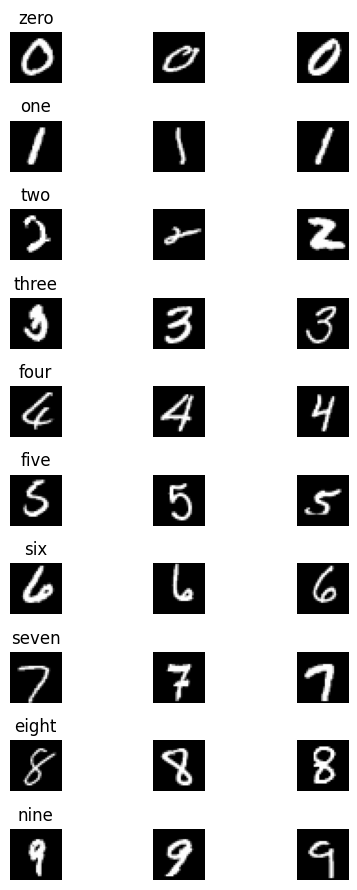

In [32]:
#Visualización de imágenes
clases = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
fig, axs = plt.subplots(10,3, figsize=(5,9))
for i in range(10):
  indice = np.where(y_train == i)[0]
  np.random.shuffle(indice)
  for j in range(3):
    axs[i,j].imshow(x_train[indice[j]], cmap='gray')
    axs[i,j].axis('off') #Saca las escalas
    if j==0:
      axs[i,j].set_title(clases[i])
plt.tight_layout()
plt.show()

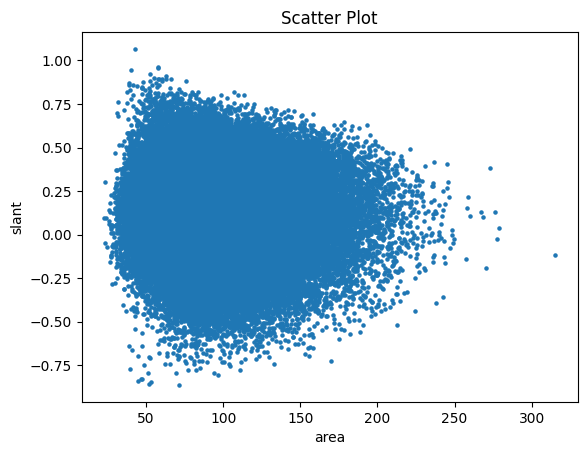

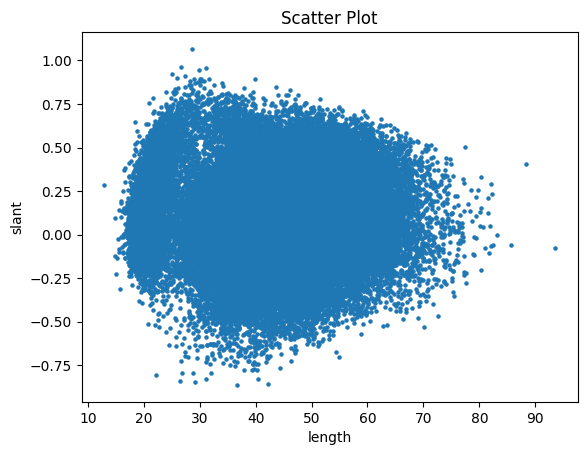

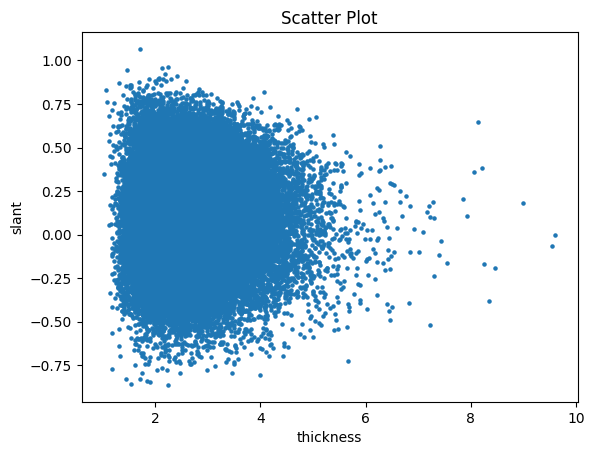

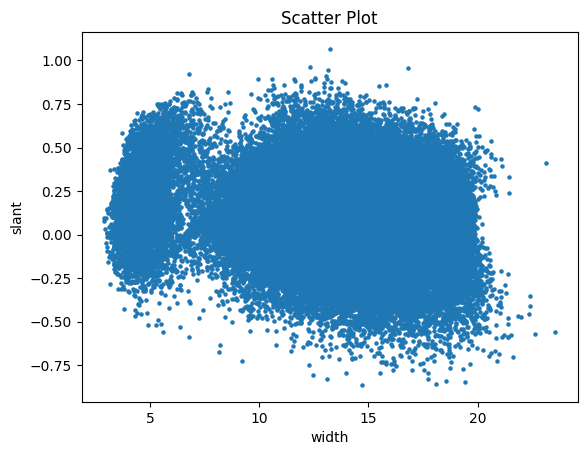

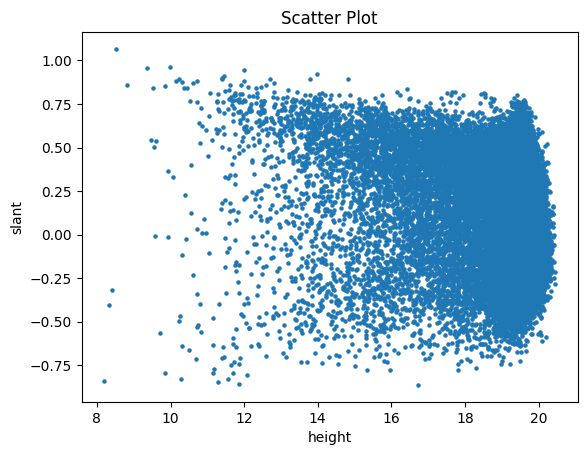

In [33]:
#Scatters
# Plotear scatter plot
y_names = ['area', 'length', 'thickness', 'width', 'height']
#fig, axs = plt.subplots(5,1, figsize=(3,6))

for y in y_names:
  plt.scatter(train_morpho[y], train_morpho['slant'], s=5)
  plt.ylabel('slant') 
  plt.xlabel(y)
  plt.title('Scatter Plot')
  # Mostrar el gráfico
  plt.show()



In [ ]:
print(train_morpho.head())
print(train_morpho.columns)

   index      area     length  thickness     slant      width     height
0      0  107.3125  50.266504   2.460658  0.231074  14.539572  19.849054
1      1  123.2500  51.198485   2.616601  0.331858  15.387810  19.341053
2      2   78.3750  45.927670   1.891592 -0.212196  20.479656  19.114880
3      3   67.3125  22.849242   2.919769  0.509185   5.358179  19.724599
4      4   91.1875  46.284271   2.247425  0.007590  13.275437  19.527523
Index(['index', 'area', 'length', 'thickness', 'slant', 'width', 'height'], dtype='object')


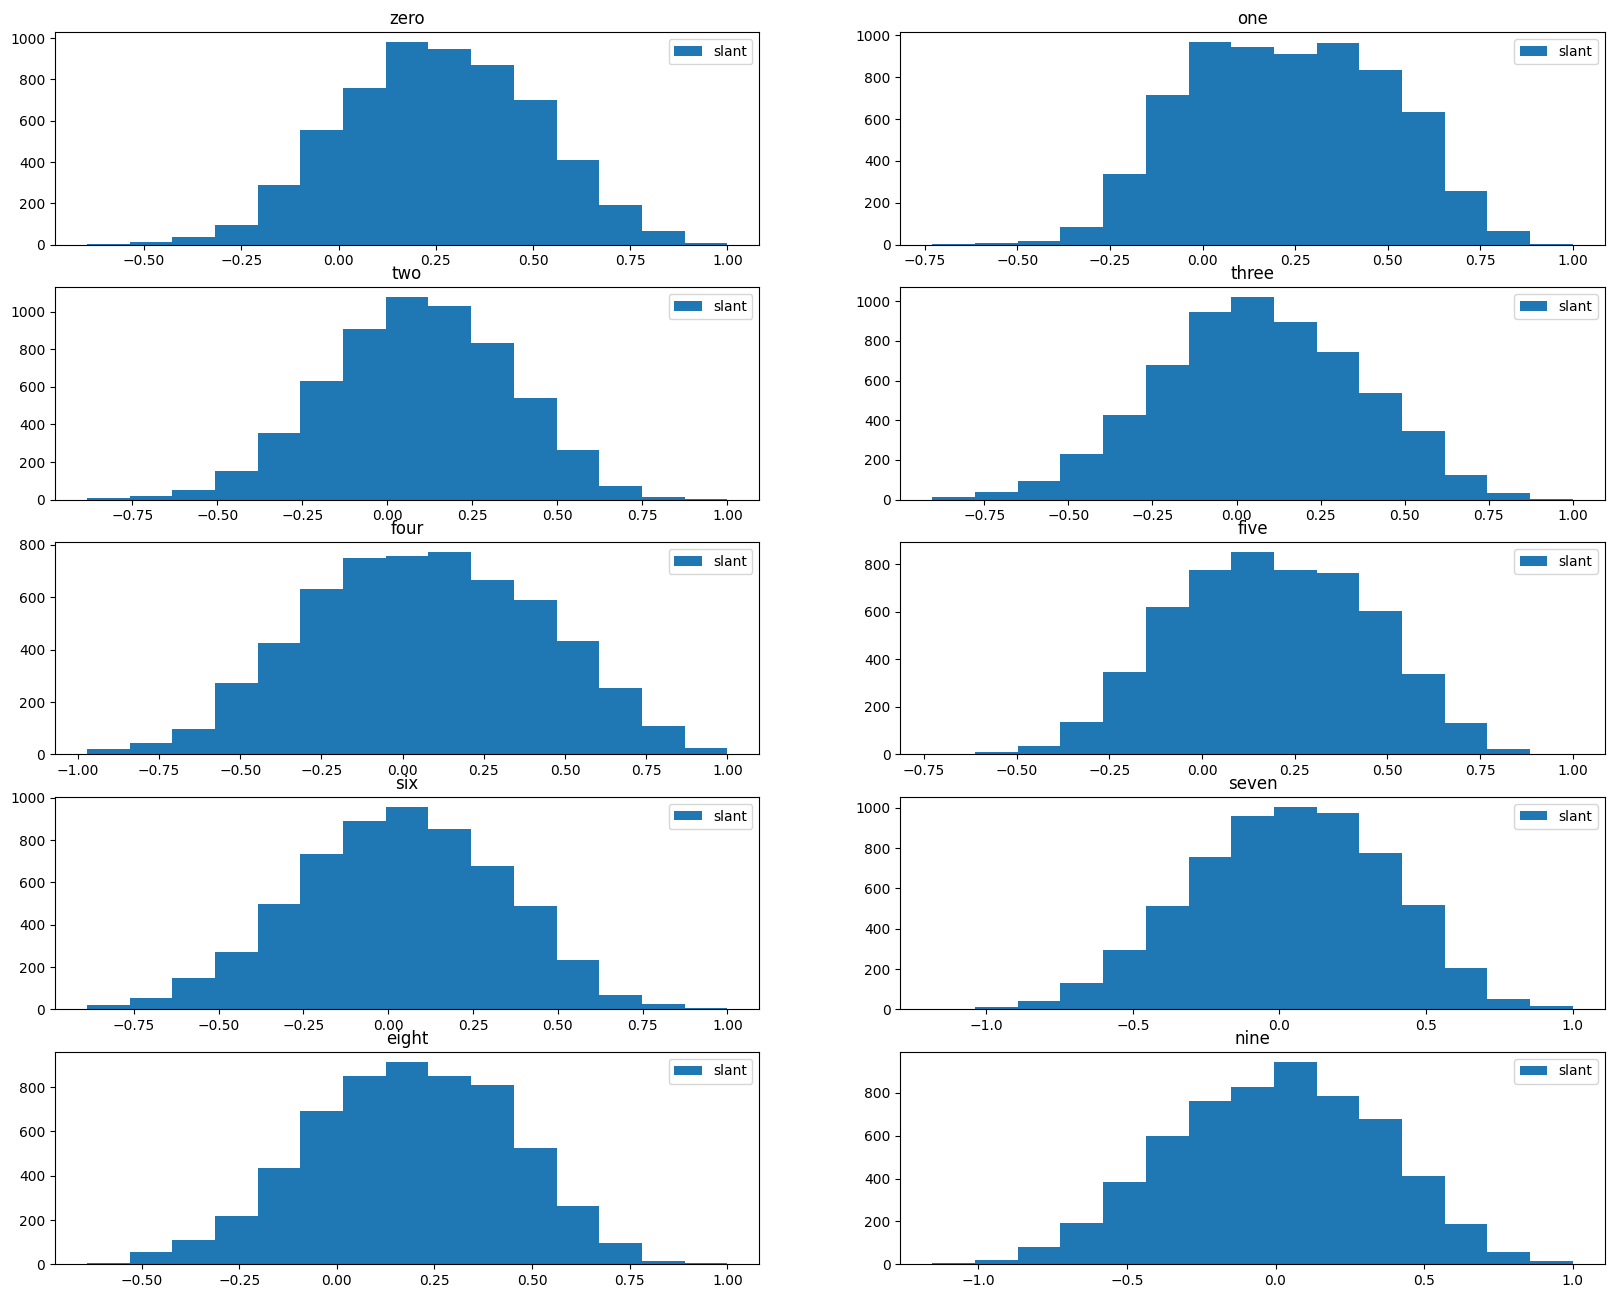

In [ ]:
#Histograma de inclinación
num_morpho = []
for i in range(10):
  num_morpho.append(train_morpho[y_train == i])
label = ['slant']
plt.figure(figsize=(20,16))
for i in range(1,6):
    plt.subplot(5,2,2*i - 1)
    for k in range(len(label)):
        a = plt.hist(num_morpho[2*i-2][label[k]].values/np.max(num_morpho[2*i-2][label[k]].values), bins=15, label = label[k], alpha = 1)
    plt.title(clases[2*i-2])
    plt.legend()
    plt.subplot(5,2,2*i)
    for k in range(len(label)):
        b = plt.hist(num_morpho[2*i-1][label[k]].values/np.max(num_morpho[2*i-1][label[k]].values), bins=15, label = label[k], alpha = 1)
    plt.title(clases[2*i-1])
    plt.legend()

In [ ]:
#Modelo para predecir la inclinación en función de la imagen
K.clear_session() 

#Definición del modelo
model= Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(BatchNormalization())
model.add(Dense(1000, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.2)) #dificulta el overfitting
model.add(Dense(1, kernel_initializer='glorot_normal'))
model.summary()

lr = 0.0001
adam = optimizers.Adam(learning_rate=lr)
model.compile(loss = 'mean_squared_error', optimizer=adam, metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)
model.fit(x=x_train,
            y=np.array(train_morpho['slant']),
            batch_size = 16,
            epochs = 50,
            verbose = 1,
            validation_data=(x_test, np.array(test_morpho['slant'])),
            callbacks=[early_stopping]
            )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1000)              785000    
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 501       
                                                        

Modelo para predecir la inclinación con la imagen y el label al que pertenece

In [ ]:
K.clear_session()

entrada_img = Input(shape=(28,28))
entrada_class = Input(shape=(1,))

emb = Embedding(10, 2, input_length=1)(entrada_class)

flat = Flatten()(entrada_img)
flat_emb = Flatten()(emb)
concat = Concatenate()([flat_emb, flat])
 
#Definición del modelo
model1 = Sequential()
model1.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model1.add(BatchNormalization())
model1.add(Dense(200, activation='relu', kernel_initializer='glorot_normal'))
model1.add(Dropout(0.2))
model1.add(Dense(1, kernel_initializer='glorot_normal'))

x=model1(concat)

model1_1 = Model(inputs=[entrada_img, entrada_class], outputs = x)
model1_1.summary()

lr = 0.0001
adam = optimizers.Adam(learning_rate=lr)
model1_1.compile(loss = 'mean_squared_error', optimizer=adam, metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)

model1_1.fit([x_train, y_train],
            np.array(train_morpho['slant']),
            batch_size = 16,
            epochs = 50,
            verbose = 1,
            validation_data=([x_test, y_test], np.array(test_morpho['slant'])),
            callbacks=[early_stopping]
            )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 2)         20          ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 2)            0           ['embedding[0][0]']              
                                                                                              

Modelo para predecir con la imagen y una variable continua más a elección. Elijo 'width'

In [ ]:
entrada1 = Input(shape=(28,28))
entrada2 = Input(shape=(1,))

flat1 = Flatten()(entrada1)
flat2 = Flatten()(entrada2)
concatenate = Concatenate()([flat1, flat2])
 
#Definición del modelo
model2 = Sequential()
model2.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model2.add(BatchNormalization())
model2.add(Dense(200, activation='relu', kernel_initializer='glorot_normal'))
model2.add(Dropout(0.2))
model2.add(Dense(1, kernel_initializer='glorot_normal'))

y=model2(concatenate)

model2_2 = Model(inputs=[entrada1, entrada2], outputs = y)
model2_2.summary()

lr = 0.0001
adam = optimizers.Adam(learning_rate=lr)
model2_2.compile(loss = 'mean_squared_error', optimizer=adam, metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)

model2_2.fit([x_train, train_morpho['width']],
            np.array(train_morpho['slant']),
            batch_size = 16,
            epochs = 50,
            verbose = 1,
            validation_data=([x_test, test_morpho['width']], np.array(test_morpho['slant'])),
            callbacks=[early_stopping]
            )

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 flatten_8 (Flatten)            (None, 784)          0           ['input_7[0][0]']                
                                                                                                  
 flatten_9 (Flatten)            (None, 1)            0           ['input_8[0][0]']                
                                                                                            

Se puede ver que a medida que se proporciona más información, el valor del mae disminuye. Esto quiere decir que la estimación es más precisa.